In [2]:
import financedatabase as fd
import pandas as pd
import numpy as np
from functools import lru_cache
import ipywidgets as widgets
from IPython.display import display
from financetoolkit import Toolkit
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
import yfinance as yf
import datetime
from pandas_datareader import data as pdr
yf.pdr_override()
equities = fd.Equities()

# ML libraries
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Sector
equities_US_sector = equities.options('sector', country='United States')
sector_dataframe=pd.DataFrame(equities_US_sector, columns=['Sector'])

# Industry Group
equities_US_industry_group = equities.options('industry_group', country='United States')
industry_group_dataframe=pd.DataFrame(equities_US_industry_group, columns=['Industry Group'])

# Industry
equities_US_industry = equities.options('industry', country='United States')
industry_dataframe=pd.DataFrame(equities_US_industry, columns=['Industry'])

# Exchanges
equities_US_exchange = np.array(['NYQ', 'PNK', 'NMS', 'ASE', 'NGM', 'NCM', 'NYS', 'BTS', 'NAS', 'PCX'])
equities_US_exchange_full_name = np.array(['New York Stock Exchange', 'OTC Bulletin Board', 'NASDAQ Global Select', 'NYSE MKT', 'Nordic Growth Market', 'NASDAQ Capital Market', 'New York Stock Exchange', 'BATS BZX Exchange', 'NASDAQ Global Select', 'NYSE Arca'])
exchange_dataframe = pd.DataFrame({'Exchange': equities_US_exchange, 'Name': equities_US_exchange_full_name})

# create 4 output widgets
sector_output = widgets.Output()
industry_group_output = widgets.Output()
industry_output = widgets.Output()
exchange_output = widgets.Output()

# display the dataframes side by side
with sector_output:
    display(sector_dataframe)
with industry_group_output:
    display(industry_group_dataframe)
with industry_output:
    display(industry_dataframe)
with industry_output:
    display(exchange_dataframe)

# Layout and display result
sector_output.layout.width = '25%'
industry_group_output.layout.width = '25%'
industry_output.layout.width = '25%'
exchange_output.layout.width = '25%'
widgets.HBox([sector_output, industry_group_output, industry_output, exchange_output])

In [3]:
# Company Overview Screener
done = False
sector_result = pd.DataFrame()
print('Pair trading works well with Financials, Materials, Utilities, Real Estate sectors and Airline industry')
while sector_result.empty:
    sector_input = input('Please enter your sector preferences')
    market_cap_input = input('Please choose one of the 4 main market caps only: Mega Cap, Large Cap, Medium Cap, Small Cap') 
    sector_result = equities.search(sector= sector_input,
                                    currency = "USD",
                                    country='United States',
                                    market_cap= market_cap_input)
                                    # exchange = exchange_input)

sector_result

Pair trading works well with Financials, Materials, Utilities, Real Estate sectors and Airline industry


Please enter your sector preferences Utilities
Please choose one of the 4 main market caps only: Mega Cap, Large Cap, Medium Cap, Small Cap Large Cap


,name,summary,currency,sector,industry_group,industry,exchange,market,country,state,city,zipcode,website,market_cap,isin,cusip,figi,composite_figi,shareclass_figi
symbol,,,,,,,,,,,,,,,,,,,
0HCT.L,Alliant Energy Corporation,Alliant Energy Corporation operates as a utili...,USD,Utilities,Utilities,Electric Utilities,LSE,London Stock Exchange (international),United States,WI,Madison,53718,http://www.alliantenergy.com,Large Cap,NaN,NaN,NaN,NaN,NaN
0HVF.L,"CenterPoint Energy, Inc.","CenterPoint Energy, Inc. operates as a public ...",USD,Utilities,Utilities,Electric Utilities,LSE,London Stock Exchange (international),United States,TX,Houston,77002,http://www.centerpointenergy.com,Large Cap,NaN,NaN,NaN,NaN,NaN
0IFJ.L,Edison International,"Edison International, through its subsidiaries...",USD,Utilities,Utilities,Electric Utilities,LSE,London Stock Exchange (international),United States,CA,Rosemead,91770,http://www.edison.com,Large Cap,US2810201077,281020107,NaN,NaN,NaN
0IJ2.L,Eversource Energy,"Eversource Energy, a public utility holding co...",USD,Utilities,Utilities,Electric Utilities,LSE,London Stock Exchange (international),United States,MA,Springfield,1104,http://www.eversource.com,Large Cap,US30040W1080,30040W108,NaN,NaN,NaN
0IJN.L,Exelon Corporation,"Exelon Corporation, a utility services holding...",USD,Utilities,Utilities,Multi-Utilities,LSE,London Stock Exchange (international),United States,IL,Chicago,60680-5379,http://www.exeloncorp.com,Large Cap,US30161N1019,30161N101,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UEPEO,Union Electric Company,"Union Electric Company, doing business as Amer...",USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,MO,Saint Louis,63103,http://www.ameren.com/missouri,Large Cap,NaN,NaN,NaN,NaN,NaN
UEPEP,Union Electric Company,"Union Electric Company, doing business as Amer...",USD,Utilities,Utilities,Electric Utilities,PNK,OTC Bulletin Board,United States,MO,Saint Louis,63103,http://www.ameren.com/missouri,Large Cap,NaN,NaN,NaN,NaN,NaN
VST,Vistra Corp.,"Vistra Corp., together with its subsidiaries, ...",USD,Utilities,Utilities,Independent Power and Renewable Electricity Pr...,NYQ,New York Stock Exchange,United States,TX,Irving,75039,http://www.vistracorp.com,Large Cap,NaN,NaN,BBG00DXDL6W4,BBG00DXDL6Q1,BBG00DXDL6R0


In [33]:
# # Get the daily prices for the above stocks
# API_KEY = "80dacf4ea5bbcdd08d8a6eb1c3ac1b29"
# companies = sector_result.to_toolkit(api_key= API_KEY, start_date="2010-10-01")
# historical_data = companies.get_historical_data()
# historical_data = pd.DataFrame(historical_data)
# historical_data

@lru_cache(maxsize=None)
def get_historical_data():
    API_KEY = "80dacf4ea5bbcdd08d8a6eb1c3ac1b29"
    companies = sector_result.to_toolkit(api_key=API_KEY, start_date="2010-10-01")
    historical_data = companies.get_historical_data()
    return pd.DataFrame(historical_data)

# Call the function to get the result
historical_data = get_historical_data()
historical_data

Obtaining historical data: 100%|███████████████████████████████████████████████████████| 65/65 [00:07<00:00,  9.26it/s]


The following tickers acquired historical data from FinancialModelingPrep: AEPPL, AEPPZ, AEE, AEP, AESC, AES, AGR, ATO, AWK, CNP-PB, CMS, CNP, DCUE, D, DTP, DTE, DUK-PA, ED, EIX, DUK, ES, ETR, EVRG, EXC, FE, LNT, NEE-PO, NEE, NEE-PQ, NEE-PN, NI-PB, NI, NIMC, NRG, PCG, PEG, PPL, SREA, SRE, PPWLM, UELMO, SO, PPWLO, UEPCN, UEPCO, UEPEM, UEPEN, UEPEO, UEPEP, UEPCP, VST, XEL, WEC, SPY
The following tickers acquired historical data from YahooFinance: 0HCT.L, 0HVF.L, 0IFJ.L, 0IJ2.L, 0IJN.L, 0IPB.L, 0K87.L, 0L5A.L
No data found for the following tickers: NEE-PP, NIMMU, SRE-PB


Open                                                          \
            0HCT.L 0HVF.L 0IFJ.L 0IJ2.L 0IJN.L 0IPB.L 0K87.L  0L5A.L   AEE   
2010-10-01     NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN 28.65   
2010-10-04     NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN 28.79   
2010-10-05     NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN 28.98   
2010-10-06     NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN 28.73   
2010-10-07     NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN 29.08   
...            ...    ...    ...    ...    ...    ...    ...     ...   ...   
2024-01-23   48.86  27.43  68.04  53.13  34.93  36.67  25.75   71.72 68.82   
2024-01-24 49.2662  27.43  67.14   53.4  34.94  37.04  25.87   72.08  69.5   
2024-01-25   48.69  27.45 66.245  54.47  34.39 36.025 25.495   70.43 68.81   
2024-01-26   48.87  27.64  67.45  55.07 34.975  36.67  25.71  71.038 69.95   
2024-01-29   48.89  27.52  67.44 54.735  34.97  36.39  25.82 70.5015 69.62   

                   ... Cumulative Return                                     \
              AEP  ...             UEPCO  UEPCP  UEPEM  UEPEN  UEPEO  UEPEP   
2010-10-01   36.4  ...               1.0    1.0    1.0    1.0    1.0    1.0   
2010-10-04  36.28  ...               1.0    1.0    1.0    1.0    1.0    1.0   
2010-10-05  36.48  ...               1.0    1.0    1.0    1.0    1.0 0.9692   
2010-10-06   36.3  ...               1.0    1.0    1.0    1.0    1.0 0.9692   
2010-10-07  36.46  ...               1.0    1.0    1.0    1.0    1.0    1.0   
...           ...  ...               ...    ...    ...    ...    ...    ...   
2024-01-23  77.38  ...            1.8796 1.7754 1.7773 1.8046 2.5986 1.7728   
2024-01-24   78.7  ...            1.8796 1.7504 1.7773 1.8046 2.5986 1.7728   
2024-01-25  78.04  ...            1.8796 1.7504 1.7773 1.8049 2.5986 1.7728   
2024-01-26  78.09  ...            1.8796 1.7504 1.7937 1.8049 1.9002 1.7728   
2024-01-29 77.845  ...            1.8522 1.7742 1.7937 1.8049 1.9093 1.7895   

                                           
              VST    WEC    XEL Benchmark  
2010-10-01    NaN    1.0    1.0       1.0  
2010-10-04    NaN 0.9937  0.998    0.9925  
2010-10-05    NaN 1.0053 1.0141    1.0125  
2010-10-06    NaN 0.9989 1.0101    1.0124  
2010-10-07    NaN 0.9984 1.0087    1.0112  
...           ...    ...    ...       ...  
2024-01-23 3.4502 4.2062 3.9752    5.4253  
2024-01-24 3.3965 4.1698   3.91    5.4312  
2024-01-25 3.5004 4.2199  3.955    5.4608  
2024-01-26 3.5307 4.2126 3.9886    5.4538  
2024-01-29 3.5117 4.2431 4.0067     5.497  

[3388 rows x 744 columns]

In [34]:
# Clean data such that the Adj Close is NaN, if so remove that row
Ticker_list = []
def filter(historical_data):
    for i in historical_data:
        if i[0] == 'Adj Close':
            if i[1] not in Ticker_list and i[1] != "Benchmark":
                Ticker_list.append(i[1])
            if historical_data[i].isnull().any():
                historical_data = historical_data[~historical_data[i].isnull()]

    # Check for inf across DataFrame
    has_inf = np.isinf(historical_data.values)
    has_inf = has_inf.any(axis=1)  

    # Filter out rows with inf 
    historical_data = historical_data[~has_inf]
    return historical_data

# Remove Benchmark column from the adj_close_data and only take the Adjusted Close column
adj_close_data = filter(historical_data)['Adj Close']
adj_close_data  = adj_close_data .drop('Benchmark', axis = 1)

adj_close_data

,0HCT.L,0HVF.L,0IFJ.L,0IJ2.L,0IJN.L,0IPB.L,0K87.L,0L5A.L,AEE,AEP,...,UEPCN,UEPCO,UEPCP,UEPEM,UEPEN,UEPEO,UEPEP,VST,WEC,XEL
2022-07-22,55.1454,29.1287,59.5572,80.4734,42.5986,37.0356,27.7102,74.7371,83.63,89.11,...,99.06,89.28,80.89,76.2,77.26,82.6,78.18,22.03,93.05,65.52
2022-07-25,56.1686,29.0357,60.2056,80.4734,43.3142,37.2729,27.9194,74.4323,84.45,90.48,...,99.06,89.28,80.89,76.2,77.26,76.99,78.18,22.37,94.1,66.27
2022-07-26,57.0116,29.0357,60.7766,80.4734,43.5898,37.9996,28.4349,74.4323,85.52,91.07,...,99.06,89.28,80.89,70.69,77.26,80.08,78.18,22.75,95.7,66.99
2022-07-27,57.1236,29.9565,61.0669,80.4734,43.3678,37.7089,28.4349,76.5313,85.51,90.95,...,99.06,89.28,80.89,70.69,77.26,82.6,78.18,22.82,95.53,67.02
2022-07-28,57.1236,30.6373,62.7025,80.4734,44.8186,38.3096,28.4349,78.8824,88.06,92.2,...,99.06,89.28,80.89,73.44,76.79,82.6,78.18,23.77,97.94,68.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-23,48.44,27.41,67.81,52.835,34.67,36.7788,25.51,71.83,69.02,78.11,...,78.05,89.3,71.0,64.8,60.04,99.97,74.3,39.85,79.75,59.19
2024-01-24,48.0687,27.41,65.455,53.24,34.175,35.89,25.21,70.1688,68.36,76.99,...,78.05,89.3,70.0,64.8,60.04,99.97,74.3,39.23,79.06,58.22
2024-01-25,48.84,27.6088,67.3,54.83,34.71,36.3,25.45,70.56,69.68,78.09,...,78.05,89.3,70.0,64.8,60.05,99.97,74.3,40.43,80.01,58.89
2024-01-26,48.805,27.6,67.4582,55.03,34.85,36.42,25.73,70.9375,69.51,77.84,...,78.05,89.3,70.0,65.4,60.05,73.1,74.3,40.78,79.87,59.39


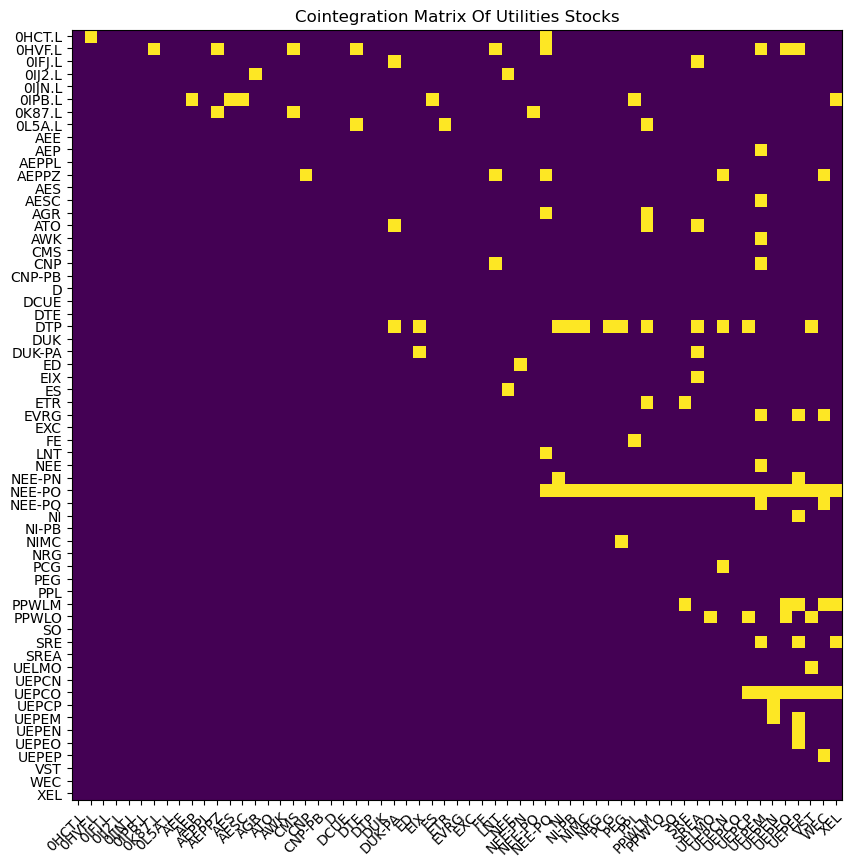

In [35]:
# Cointegration Test to find the best pairs
def cointegration_checker(stock_dataframe):
    cointegrated_pairs = []
    
    k = stock_dataframe.shape[1]
    #getting the number of columns (tickers)
    p_values = np.ones( (k, k) )
    
    
    keys = stock_dataframe.keys()
    #getting the column names (tickers) from df
    
    for i in range(k-1):
        for j in range(i+1, k):
            
            Asset_1 = stock_dataframe[keys[i]]
            Asset_2 = stock_dataframe[keys[j]]
            
            #iterating through the df and testing cointegration for all pairs of tickers
            if Asset_1.min() != Asset_1.max() and Asset_2.min() != Asset_2.max():
                Coint_Test = coint(Asset_1, Asset_2)
            
                pvalue = Coint_Test[1]
                # statsmodels coint returns p-values (our primary concern) in the 1th index slot
                p_values[i, j] = pvalue
                #p value matrix where the output of the coint test is the ith, jth index
                if pvalue < 0.02:
                    cointegrated_pairs.append((keys[i], keys[j], pvalue))
                
    return p_values, cointegrated_pairs

# # Display the results
pvalues, pairs = cointegration_checker(adj_close_data)

fig, ax = plt.subplots(figsize=(25, 10))
im = ax.imshow(pvalues <= .02)

ax.set_xticks(np.arange(len(Ticker_list)))
ax.set_yticks(np.arange(len(Ticker_list)))

ax.set_xticklabels(Ticker_list)
ax.set_yticklabels(Ticker_list)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title(f"Cointegration Matrix Of {sector_input} Stocks")
plt.show()

def myfunc(n):
    return n[2]

pairs.sort(key = myfunc, reverse = True)

In [36]:
res1 = []
for i in pairs:
    placeholder, pvalue, placeholder2 = coint(adj_close_data[i[1]][0:252], adj_close_data[i[0]][0:252])
    print(f"The pvalue of the augmented Engle-Granger two-step cointegration test between {i[1]} and {i[0]} is", pvalue)

The pvalue of the augmented Engle-Granger two-step cointegration test between 0HVF.L and 0HCT.L is 0.07805896549452555
The pvalue of the augmented Engle-Granger two-step cointegration test between UEPEO and 0HVF.L is 0.002283709947409363
The pvalue of the augmented Engle-Granger two-step cointegration test between PEG and NIMC is 0.11047348870001916
The pvalue of the augmented Engle-Granger two-step cointegration test between UEPEM and AESC is 0.002467034312936235
The pvalue of the augmented Engle-Granger two-step cointegration test between UELMO and PPWLO is 0.11657605952206068
The pvalue of the augmented Engle-Granger two-step cointegration test between PPWLM and DTP is 0.008848235831755383
The pvalue of the augmented Engle-Granger two-step cointegration test between PPWLM and AGR is 1.0077699033837124e-05
The pvalue of the augmented Engle-Granger two-step cointegration test between LNT and CNP is 0.25429047167159813
The pvalue of the augmented Engle-Granger two-step cointegration te

In [37]:
res = []
for i in range(len(pairs)):
    Asset_1 = adj_close_data[pairs[i][1]]
    Asset_2 =  adj_close_data[pairs[i][0]]
    price_ratio = Asset_1/Asset_2
    result_price_ratio = adfuller(price_ratio, autolag = "AIC")

    # Determine which of the spread or the price ratio is stationary
    const  = add_constant(Asset_1)
    results = OLS(Asset_2, const).fit()
    coef = results.params[pairs[i][1]]
    spread = Asset_2 - (coef * Asset_1)
    result_spread =adfuller(price_ratio, autolag = "AIC")
    
    lst = []
    if result_price_ratio[1] > 0.1:
        lst.append("Price Ratio is not stationary")
    else:
        lst.append("Price Ratio is stationary")

    if result_spread[1] > 0.1:
        lst.append("Spread is not stationary")
    else:
        lst.append("Spread is stationary")

    if lst[0] == "Price Ratio is not stationary":
        print(f"Since {lst[0]}, then I would suggest you choose a different pair because {lst[1]}, which makes the strategy fail as we won't be able to find their divergence at all.")
    else:
        res.append((pairs[i][1], pairs[i][0],i))
        print(f"Yes, the pair of {pairs[i][1]} and {pairs[i][0]} works well as {lst[0]} and will likely fluctuate around a mean of {price_ratio.mean()} {[i]}")

Yes, the pair of 0HVF.L and 0HCT.L works well as Price Ratio is stationary and will likely fluctuate around a mean of 0.5500819114235258 [0]
Yes, the pair of UEPEO and 0HVF.L works well as Price Ratio is stationary and will likely fluctuate around a mean of 2.658846495282772 [1]
Yes, the pair of PEG and NIMC works well as Price Ratio is stationary and will likely fluctuate around a mean of 0.5983727039880473 [2]
Since Price Ratio is not stationary, then I would suggest you choose a different pair because Spread is not stationary, which makes the strategy fail as we won't be able to find their divergence at all.
Yes, the pair of UELMO and PPWLO works well as Price Ratio is stationary and will likely fluctuate around a mean of 0.6482918210837495 [4]
Since Price Ratio is not stationary, then I would suggest you choose a different pair because Spread is not stationary, which makes the strategy fail as we won't be able to find their divergence at all.
Yes, the pair of PPWLM and AGR works we

In [38]:
done = False
while not done:
    index = int(input("Enter the index of your chosen pair please: "))
    consider = input("Do you want to reconsider your options? (y/n): ")
    if consider.lower() == 'n':
        done = True

index

Enter the index of your chosen pair please:  117
Do you want to reconsider your options? (y/n):  n


117

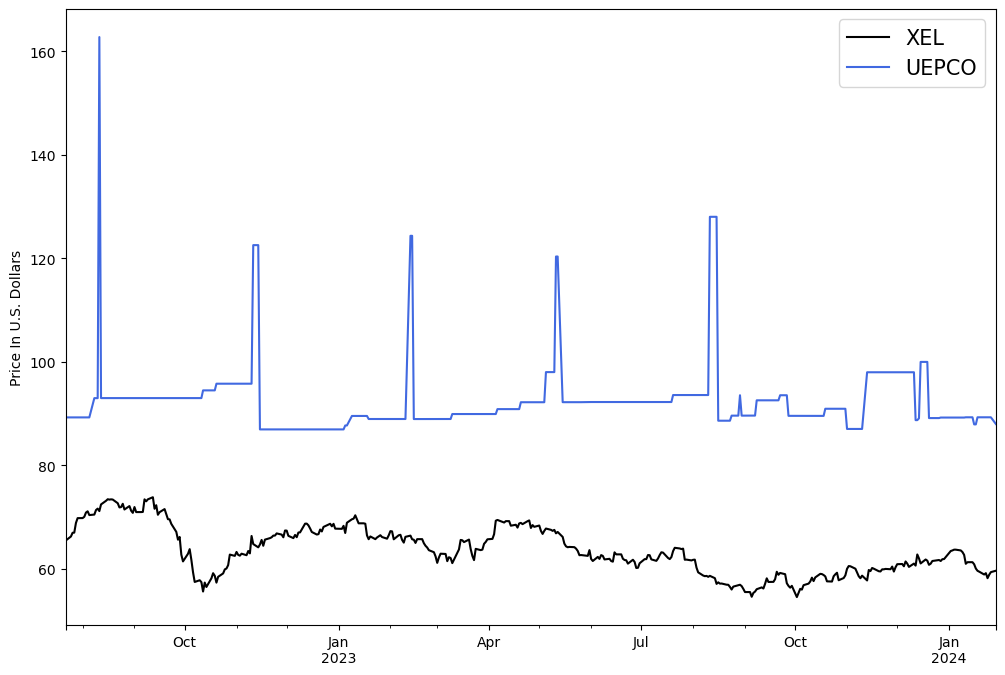

In [39]:
plt.figure(figsize=(12,8))
adj_close_data[pairs[index][1]].plot(color = 'black')
adj_close_data[pairs[index][0]].plot(color = 'royalblue')
plt.legend([pairs[index][1], pairs[index][0]], prop={'size': 15})
plt.ylabel('Price In U.S. Dollars')
plt.show()

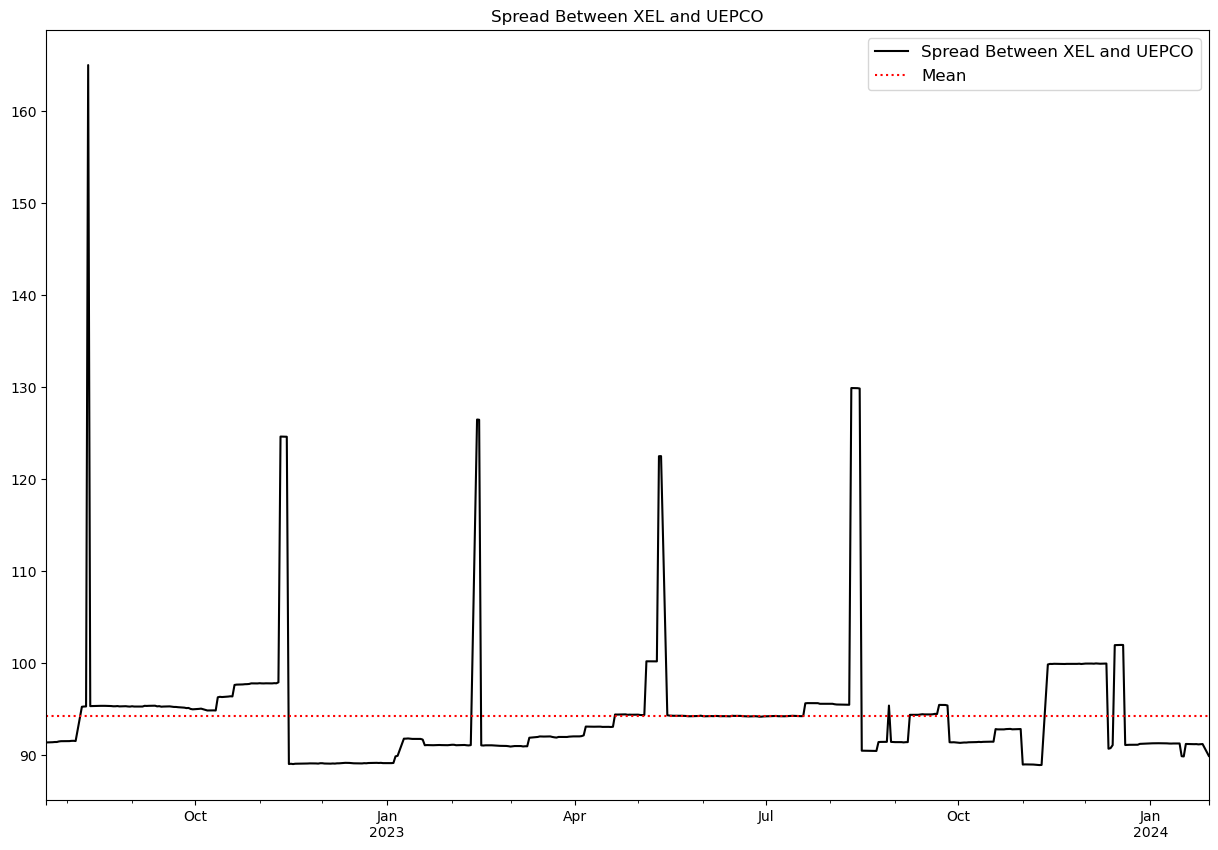

In [40]:
adj_close_data = pd.DataFrame(adj_close_data)
Asset_1 = adj_close_data[pairs[index][1]]
Asset_2 =  adj_close_data[pairs[index][0]]

#calculating the spread
Asset_1  = add_constant(Asset_1)
results = OLS(Asset_2, Asset_1).fit()

coef = results.params[pairs[index][1]]
Asset_1 = Asset_1[pairs[index][1]]

spread = Asset_2 - (coef * Asset_1)
spread.plot(figsize=(15,10), color = 'black')
begin_date = adj_close_data.index[0].strftime('%Y-%m-%d')
end_date = adj_close_data.index[len(adj_close_data.index) - 1].strftime('%Y-%m-%d')
plt.xlim(begin_date, end_date)
plt.axhline(spread.mean(), color='red', linestyle=':')
plt.legend([f"Spread Between {pairs[index][1]} and {pairs[index][0]}", 'Mean'], prop={'size': 12});
plt.title(f"Spread Between {pairs[index][1]} and {pairs[index][0]}")
plt.show()

In [41]:
# Check if the price ratio is stationary or not
# ADF (Augmented Dickey Fuller) Test for price ratio

price_ratio_output = widgets.Output()
with price_ratio_output:
    result_price_ratio = adfuller(price_ratio, autolag = "AIC")
    display(f'ADF Statistic for Price Ratio: {result_price_ratio[0]}')
    display(f'n_lags: {result_price_ratio[1]}')
    display(f'p-value: {result_price_ratio[1]}')
    for key, value in result_price_ratio[4].items():
        display('Critial Values:')
        display(f'   {key}, {value}')    

# Check if the spread is stationary or not
# ADF (Augmented Dickey Fuller) Test for spread
spread_output = widgets.Output() 
with spread_output:  
    result_spread = adfuller(spread, autolag = "AIC")
    display(f'ADF Statistic for spread: {result_spread[0]}')
    display(f'n_lags: {result_spread[1]}')
    display(f'p-value: {result_spread[1]}')
    for key, value in result_spread[4].items():
        display('Critial Values:')
        display(f'   {key}, {value}')   

# Layout and display result
price_ratio_output.layout.width = '50%'
spread_output.layout.width = '50%'
widgets.HBox([price_ratio_output, spread_output])

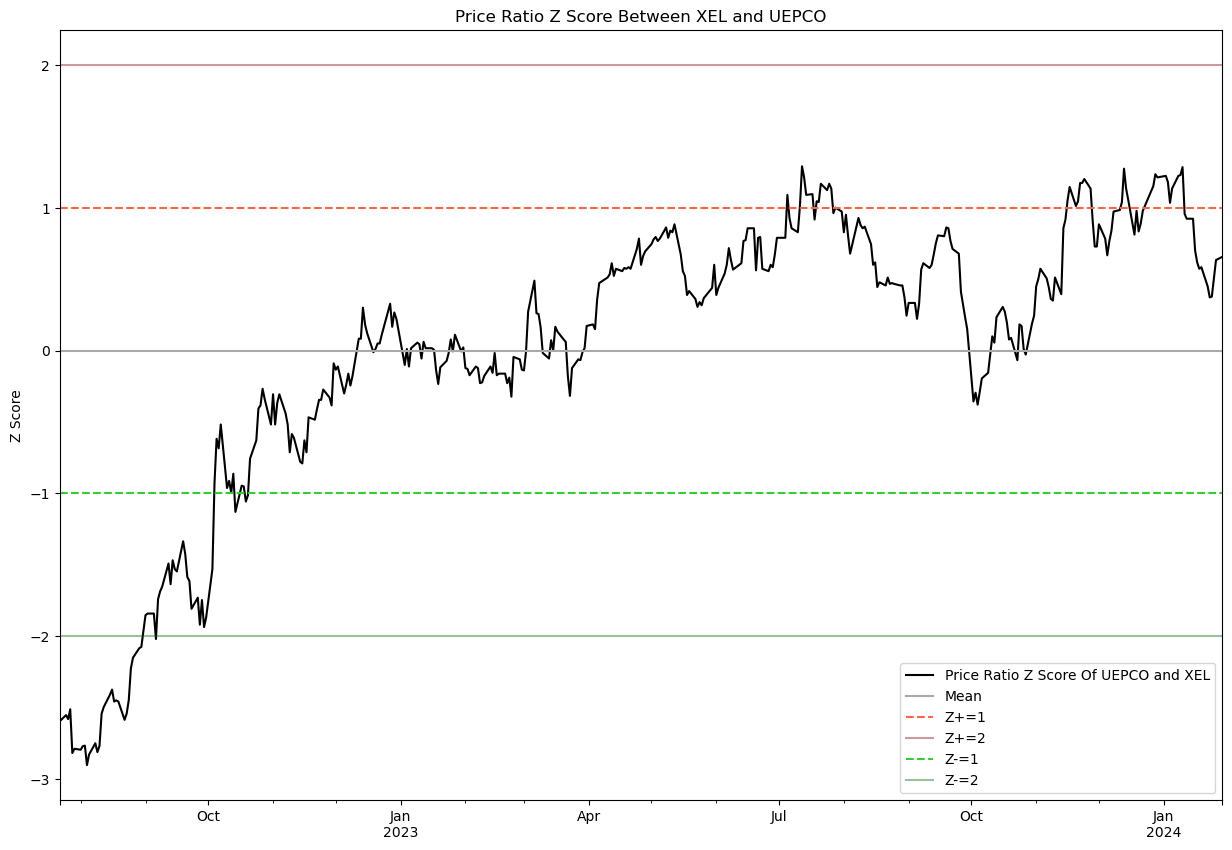

In [42]:
# Convert Price Ratio to Z-score for normalization
price_ratio_z_score = (price_ratio - price_ratio.mean()) / np.std(price_ratio)

price_ratio_z_score.plot(figsize=(15,10), color = 'black')
plt.axhline(price_ratio_z_score.mean(), color = 'darkgrey' )
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(2, color='darkred', alpha = .4)
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.axhline(-2, color='darkgreen', alpha = .4)


plt.xlim(begin_date, end_date)
plt.legend([f'Price Ratio Z Score Of {pairs[index][0]} and {pairs[index][1]}', 'Mean', 'Z+=1', 'Z+=2', 'Z-=1', 'Z-=2' ]);
plt.title(f"Price Ratio Z Score Between {pairs[index][1]} and {pairs[index][0]}")
plt.ylabel('Z Score')

plt.show()

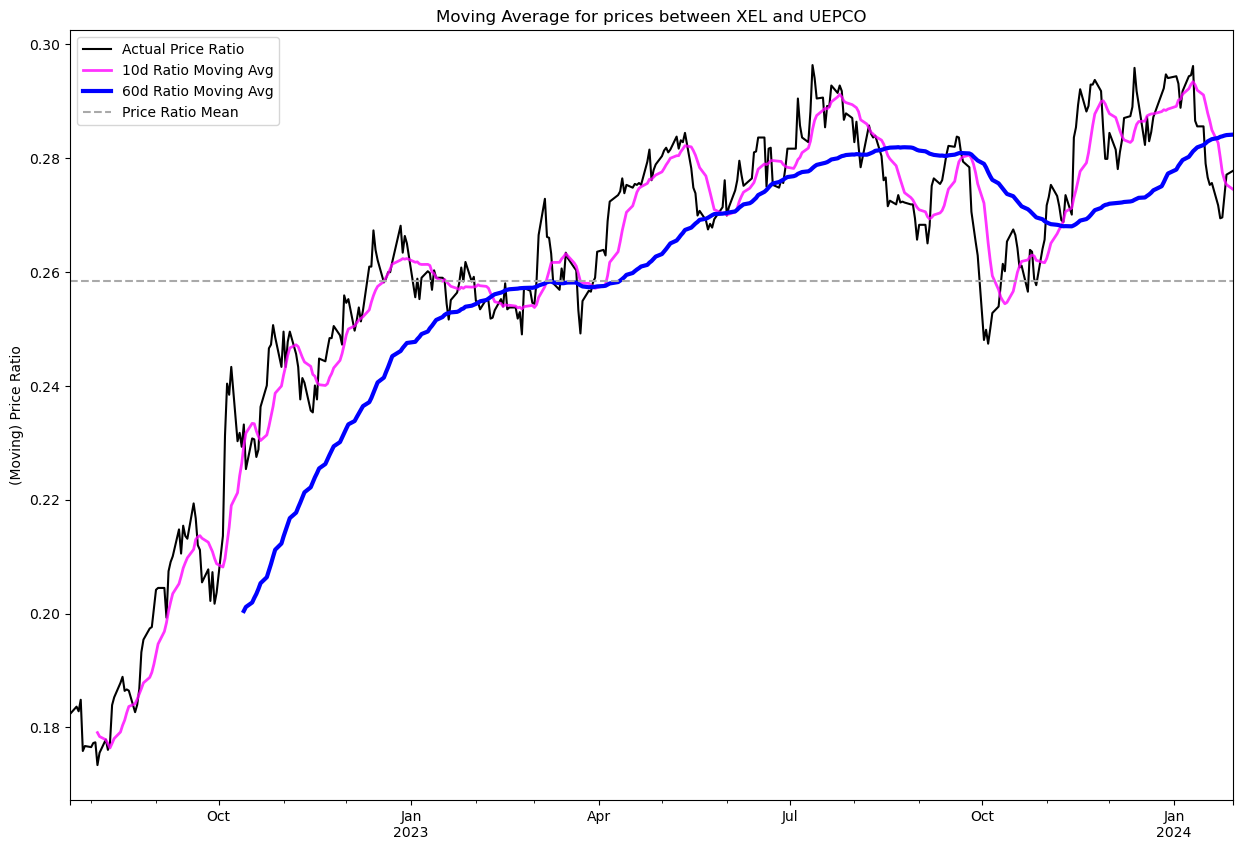

In [43]:
# Moving Averages for 10 and 60 days
price_ratio_10D_MAVG = price_ratio.rolling(window=10, center = False).mean() 
price_ratio_60D_MAVG = price_ratio.rolling(window=60, center = False).mean() 

plt.figure(figsize=(15, 10))
price_ratio.plot(color = 'black')
price_ratio_10D_MAVG.plot(color = 'magenta', linewidth=2, alpha = .8)
price_ratio_60D_MAVG.plot(color = 'b', linewidth=3)
plt.axhline(price_ratio.mean(), color = 'darkgrey', linestyle = 'dashed' )
plt.legend(['Actual Price Ratio', '10d Ratio Moving Avg', '60d Ratio Moving Avg', 'Price Ratio Mean'])
plt.title(f"Moving Average for prices between {pairs[index][1]} and {pairs[index][0]}")
plt.ylabel('(Moving) Price Ratio')
plt.show()

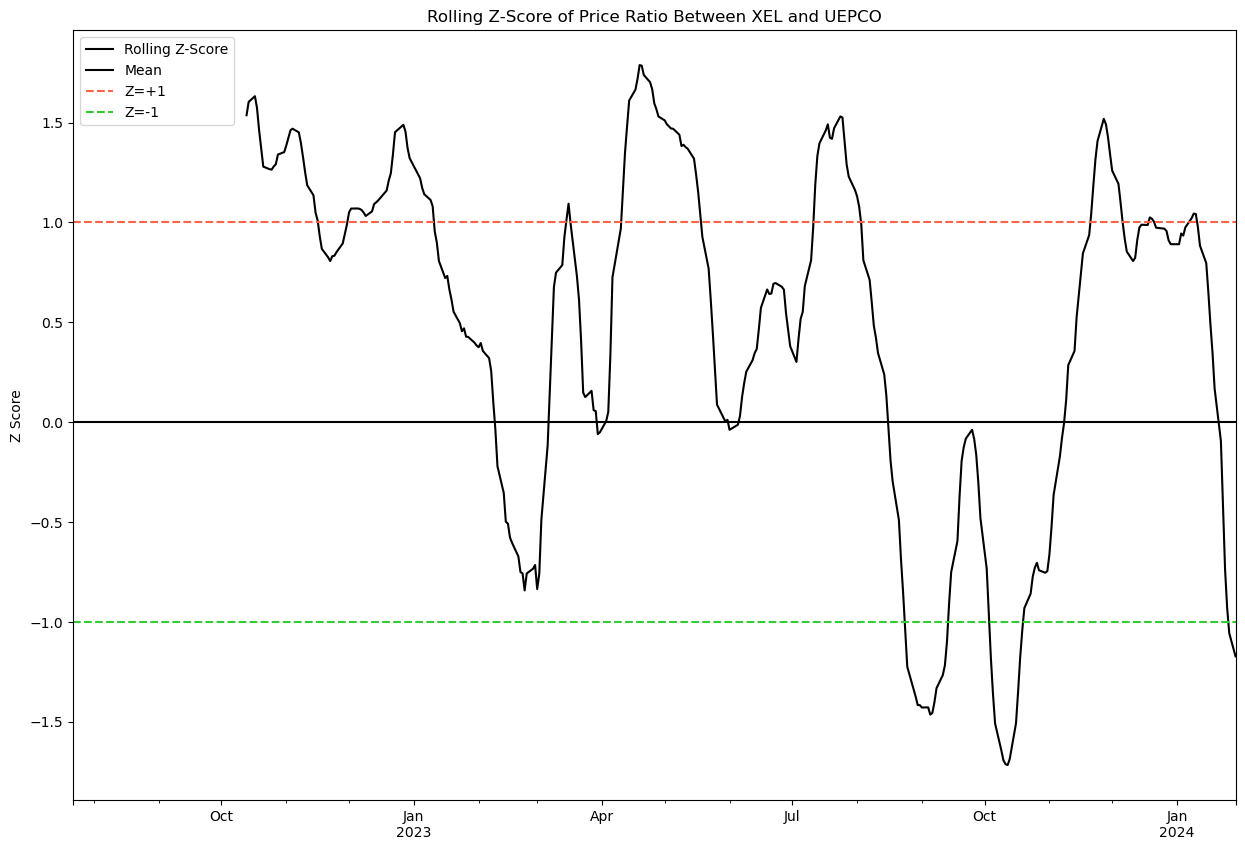

In [44]:
# Moving Average Z-Scores
STD_60 = price_ratio.rolling(window=60, center = False).std()
Rolling_Z_Score = ((price_ratio_10D_MAVG - price_ratio_60D_MAVG)/STD_60)
Rolling_Z_Score.plot(figsize=(15,10), color = 'black')

plt.xlim(begin_date, end_date)
plt.axhline(0, color='black')
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.legend(['Rolling Z-Score', 'Mean', 'Z=+1', 'Z=-1'])
plt.title(f"Rolling Z-Score of Price Ratio Between {pairs[index][1]} and {pairs[index][0]}")
plt.ylabel('Z Score')
plt.show()

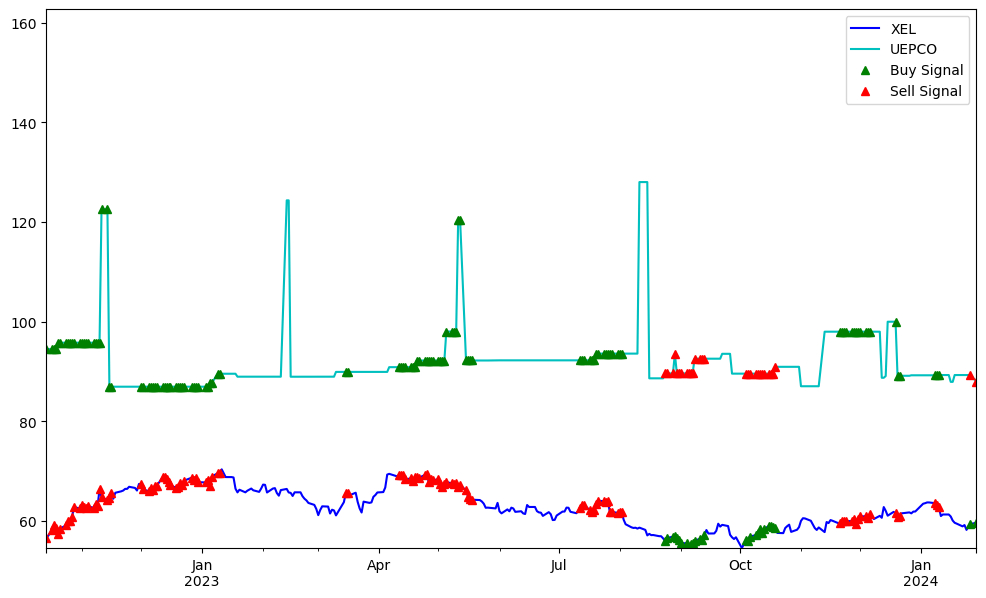

In [45]:
plt.figure(figsize=(12,7))
buy = price_ratio.copy()
sell = price_ratio.copy()
buy[Rolling_Z_Score>-1] = 0
sell[Rolling_Z_Score<1] = 0
S1 = Asset_1
S2 = Asset_2

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.legend([pairs[index][1], pairs[index][0], 'Buy Signal', 'Sell Signal'])
plt.show()

In [46]:
# Extract the data of the stock pairs into seperate ones and re adjust to fit the training of Prophet

# Reset index of the whole dataframe to form as column named ds
adj_close_data.reset_index(inplace=True)
adj_close_data.rename(columns={"index":"ds"},inplace=True)

# Extract the data of the 2 stocks in the pair individually
first_stock_data = adj_close_data[['ds', pairs[index][1]]]
second_stock_data = adj_close_data[['ds',pairs[index][0]]]

# Rename the stock price column to y
first_stock_data.rename(columns={pairs[index][1]:"y"},inplace=True)
second_stock_data.rename(columns={pairs[index][0]:"y"},inplace=True)
first_stock_data['ds'] = first_stock_data['ds'].dt.to_timestamp()
second_stock_data['ds'] = second_stock_data['ds'].dt.to_timestamp()

C:\Users\buitu\AppData\Local\Temp\ipykernel_29612\3797293419.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_stock_data.rename(columns={pairs[index][1]:"y"},inplace=True)
C:\Users\buitu\AppData\Local\Temp\ipykernel_29612\3797293419.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_stock_data.rename(columns={pairs[index][0]:"y"},inplace=True)
C:\Users\buitu\AppData\Local\Temp\ipykernel_29612\3797293419.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [47]:
# Fine-Tuning Hyperparameter for the Prophet prediction model
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(first_stock_data)  # Fit model with given params
    df_cv = cross_validation(m, initial= f'{int(len(adj_close_data) * 70/100)} days', period= f'{int(len(adj_close_data) * 70/600)} days', horizon= f'{int(len(adj_close_data) * 70/300)} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

20:57:40 - cmdstanpy - INFO - Chain [1] start processing
20:57:40 - cmdstanpy - INFO - Chain [1] done processing
20:57:42 - cmdstanpy - INFO - Chain [1] start processing
20:57:42 - cmdstanpy - INFO - Chain [1] done processing
20:57:44 - cmdstanpy - INFO - Chain [1] start processing
20:57:44 - cmdstanpy - INFO - Chain [1] done processing
20:57:46 - cmdstanpy - INFO - Chain [1] start processing
20:57:46 - cmdstanpy - INFO - Chain [1] done processing
20:57:48 - cmdstanpy - INFO - Chain [1] start processing
20:57:48 - cmdstanpy - INFO - Chain [1] done processing
20:57:49 - cmdstanpy - INFO - Chain [1] start processing
20:57:50 - cmdstanpy - INFO - Chain [1] done processing
20:57:51 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing
20:57:53 - cmdstanpy - INFO - Chain [1] start processing
20:57:53 - cmdstanpy - INFO - Chain [1] done processing
20:57:55 - cmdstanpy - INFO - Chain [1] start processing
20:57:56 - cmdstanpy - INFO - Chain [1]

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.001,0.01,4.4628251888754935
1,0.001,0.1,4.591418519083697
2,0.001,1.0,4.57065763833535
3,0.001,10.0,4.565364581437527
4,0.01,0.01,4.270438808835775
5,0.01,0.1,4.181951079544748
6,0.01,1.0,4.236978494949166
7,0.01,10.0,4.207983991750643
8,0.1,0.01,7.490764352518209
9,0.1,0.1,7.52060060548929


In [48]:
# Generate all combinations of parameters
all_params1 = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses1 = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params1:
    m = Prophet(**params).fit(second_stock_data)  # Fit model with given params
    # df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_cv = cross_validation(m, initial= f'{int(len(adj_close_data) * 70/100)} days', period= f'{int(len(adj_close_data) * 70/600)} days', horizon= f'{int(len(adj_close_data) * 70/300)} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses1.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results1 = pd.DataFrame(all_params1)
tuning_results1['rmse'] = rmses1
tuning_results1

20:58:13 - cmdstanpy - INFO - Chain [1] start processing
20:58:13 - cmdstanpy - INFO - Chain [1] done processing
20:58:14 - cmdstanpy - INFO - Chain [1] start processing
20:58:15 - cmdstanpy - INFO - Chain [1] done processing
20:58:16 - cmdstanpy - INFO - Chain [1] start processing
20:58:16 - cmdstanpy - INFO - Chain [1] done processing
20:58:18 - cmdstanpy - INFO - Chain [1] start processing
20:58:18 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:23 - cmdstanpy - INFO - Chain [1] start processing
20:58:23 - cmdstanpy - INFO - Chain [1] done processing
20:58:25 - cmdstanpy - INFO - Chain [1] start processing
20:58:25 - cmdstanpy - INFO - Chain [1] done processing
20:58:27 - cmdstanpy - INFO - Chain [1] start processing
20:58:27 - cmdstanpy - INFO - Chain [1] done processing
20:58:29 - cmdstanpy - INFO - Chain [1] start processing
20:58:29 - cmdstanpy - INFO - Chain [1]

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.001,0.01,6.357432353087501
1,0.001,0.1,6.350209441741131
2,0.001,1.0,6.34144046384236
3,0.001,10.0,6.337721815951405
4,0.01,0.01,6.530060262747378
5,0.01,0.1,6.55282039463823
6,0.01,1.0,6.55555201790365
7,0.01,10.0,6.537843038101475
8,0.1,0.01,6.459861191274897
9,0.1,0.1,6.449878901899107


20:58:45 - cmdstanpy - INFO - Chain [1] start processing
20:58:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\buitu\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\buitu\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


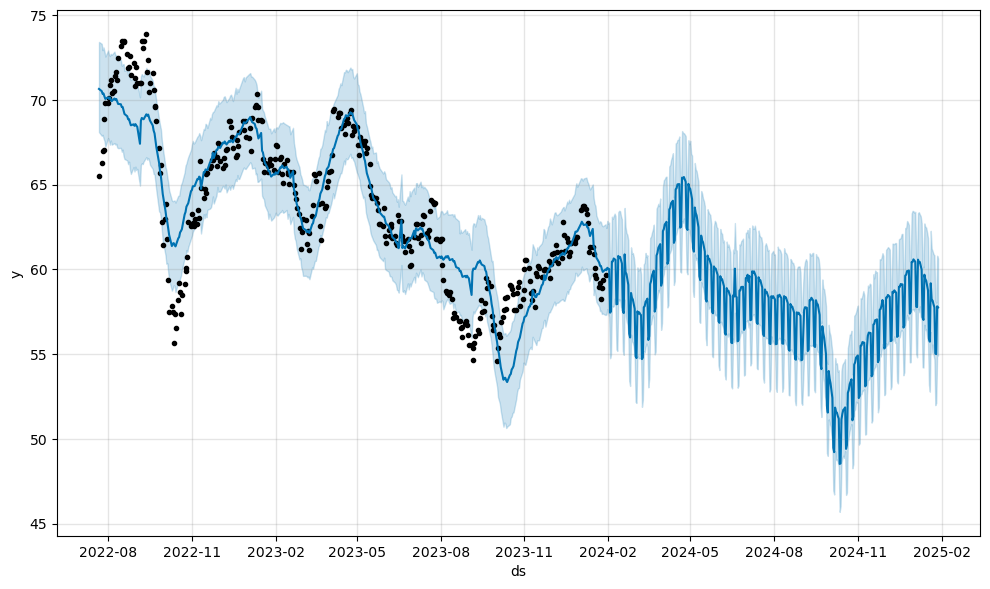

In [49]:
best_params = all_params[np.argmin(rmses)]
best_params1 = all_params1[np.argmin(rmses1)]

def train_prophet_model(data):
    if data.equals(first_stock_data) == True:
        model = Prophet(
            changepoint_prior_scale= best_params['changepoint_prior_scale'],
            holidays_prior_scale=15,
            seasonality_prior_scale= best_params['seasonality_prior_scale'],
            weekly_seasonality=True,
            yearly_seasonality=True,
            daily_seasonality=False,
        )
        model.add_country_holidays(country_name="US")
        model.fit(data)
        return model
    
    else:
        model = Prophet(
            changepoint_prior_scale= best_params1['changepoint_prior_scale'],
            holidays_prior_scale=15,
            seasonality_prior_scale= best_params1['seasonality_prior_scale'],
            weekly_seasonality=True,
            yearly_seasonality=True,
            daily_seasonality=False,
        )
        model.add_country_holidays(country_name="US")
        model.fit(data)
        return model


def generate_forecast(model, periods=365):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast


def plot_forecast(model, forecast):
    model.plot(forecast)

#Train Prophet model
first_model = train_prophet_model(first_stock_data)

# Generate forecast
first_forecast = generate_forecast(first_model)

# Plot forecast
plot_forecast(first_model, first_forecast)

20:58:45 - cmdstanpy - INFO - Chain [1] start processing
20:58:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\buitu\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\buitu\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


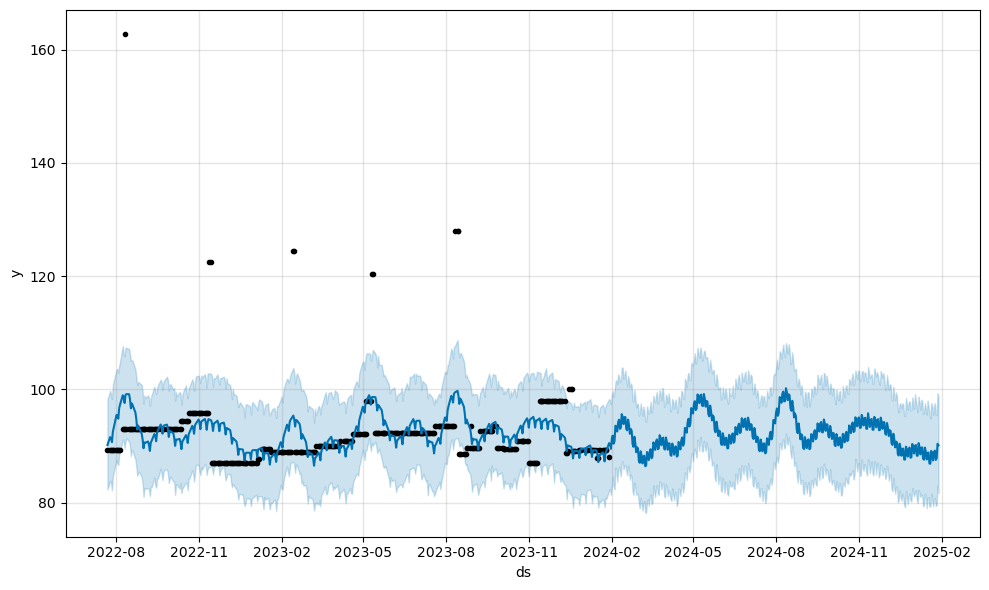

In [50]:
#Train Prophet model
second_model = train_prophet_model(second_stock_data)

# Generate forecast
second_forecast = generate_forecast(second_model)

# Plot forecast
plot_forecast(second_model, second_forecast)

In [51]:
# Filling out predicted to observed data for each pair
# Reset index
first_stock_data = first_stock_data.set_index('ds')

# Filter out future prices from known ones
rslt_df = first_forecast[first_forecast['ds'] > end_date] 
rslt_df = rslt_df.set_index('ds')
rslt_df = rslt_df['yhat']
result = first_stock_data['y']._append(rslt_df)
result.index.to_period("D")

second_stock_data = second_stock_data.set_index('ds')

# Filter out future prices from known ones
rslt_df1 = second_forecast[second_forecast['ds'] > end_date] 
rslt_df1= rslt_df1.set_index('ds')
rslt_df1 = rslt_df1['yhat']
result1 = second_stock_data['y']._append(rslt_df1)
result1.index.to_period("D")

PeriodIndex(['2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
             '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
             '2022-08-03', '2022-08-04',
             ...
             '2025-01-19', '2025-01-20', '2025-01-21', '2025-01-22',
             '2025-01-23', '2025-01-24', '2025-01-25', '2025-01-26',
             '2025-01-27', '2025-01-28'],
            dtype='period[D]', name='ds', length=756)

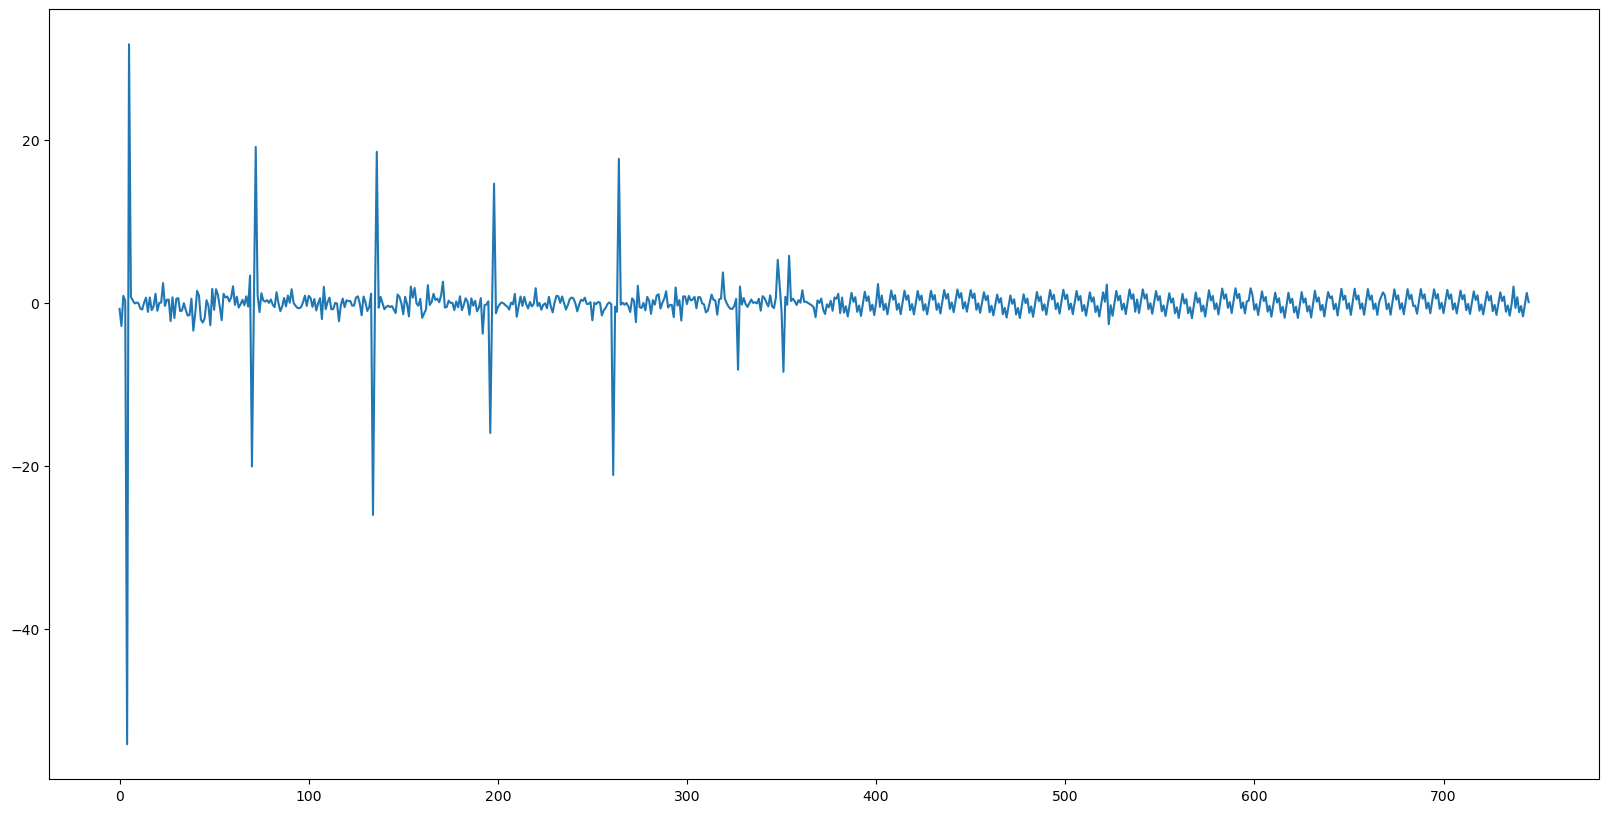

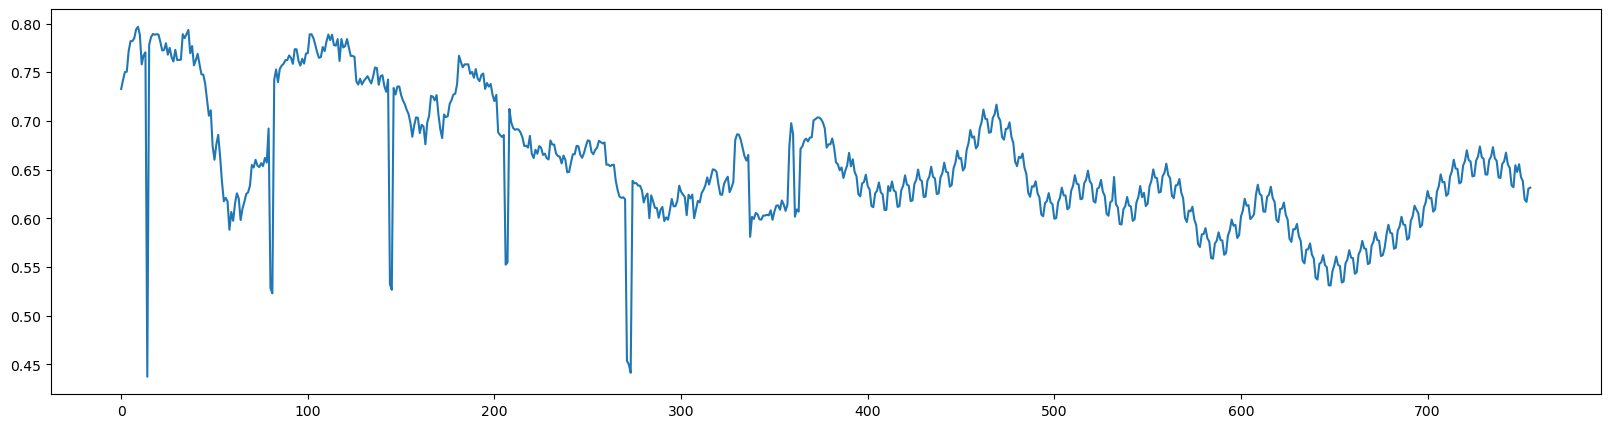

In [52]:
# Kalman Filter for Pair Trading: avoid Moving Average and have better estimate of z_score
class MyKalmanFilter:
    def __init__(self, delta=1e-4, R=1e-3):
        # measurement noise variance
        self.R = R

        # co-variance of process noise(2 dimensions)
        self.Q = delta / (1-delta) * np.eye(2)

        # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
        self.x = np.zeros((2, 1))     

        # state covariance
        self.P = np.zeros((2,2))     

    def step_forward(self, y1, y2):
        # Before entering the equations, let's define H as (1, 2) matrix
        H = np.array([y2, 1])[None]
        # and define z
        z = y1

        ## TIME UPDATE ##
        # first thing is to predict new state as the previous one (2x1)
        x_hat = self.x[:, -1][..., None]

        # then, the uncertainty or covariance prediction 
        P_hat = self.P + self.Q

        ## MEASUREMENT UPDATE ##
        # calc the Kalman gain
        K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

        # state update part 1 (measurement estimation)
        z_hat = H.dot(x_hat)
        # state update part 2
        x = x_hat + K.dot(z-z_hat)

        # uncertainty update
        self.P = (np.eye(2)-K.dot(H)).dot(P_hat)

        # append the new state to the vector
        self.x = np.concatenate([self.x, x], axis=1)

        return x, P_hat, K, z_hat

mkf = MyKalmanFilter(delta=1e-4, R=1e-3)
series = []
# Create a new DataFrame
df = pd.DataFrame({
    pairs[0][1]: result,
    pairs[0][0]: result1
})
for idx, row in df.iterrows():
    x, P, K, z_hat = mkf.step_forward(row[pairs[0][1]], row[pairs[0][0]])
    series.append(row[pairs[0][1]] - z_hat.squeeze())

# Plot the combined portfolio
plt.figure(figsize=(20,10))
plt.plot(series[10:])

# Plot the hedge ratio over time
plt.figure(figsize=(20,5))
plt.plot(mkf.x[0, 1:])

In [53]:
# Pair Trading Simulation
def trading_simulation(Asset1, Asset2, window1, window2, leverage, stop_loss, Kalman_Filter):
    # calculating the z score with moving averages as shown in previous sections
    price_ratio = Asset1/Asset2
    moving_average1 = price_ratio.rolling(window=window1).mean()
    moving_average2 = price_ratio.rolling(window=window2).mean()
    std = price_ratio.rolling(window=window2).std()
    z_score = ((moving_average1-moving_average2)/std)
    
    # Decide whether to use Kalmin Filter or not
    if Kalman_Filter == False:
        Kalman = z_score
    else:
        z_score = Kalman = pd.Series(series)
        # Reset index  
        Kalman.reset_index(drop=True, inplace=True)

        # Set index to match series1
        Kalman.index = z_score.index
    
    profit, profit_high, profit_low = 0,0,0
    ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
    low_trade_total, high_trade_total, = 0,0
    count_high, count_low = 0,0
    old_profit_high, old_profit_low = 0,0
    high_hit_rate, low_hit_rate = [], []
    low_dic, high_dic = {}, {}
    Asset1_shares, Asset2_shares = 0,0
    open_trade = 0
    potential_loss_high, potential_loss_low  = 0,0
    
    df = pd.DataFrame(columns = ['Date', 'Profit'])
    
    for i in range(len(price_ratio)):
        if Kalman.loc[i] > 1.25 and open_trade == 0: 
        #if the price ratio z score is high we will 'sell' the ratio 
        
            #calculating the maximum number of shares for each stock; positions are weighted equally
            Asset1_shares = (leverage // 2) // Asset1.iloc[i]
            Asset2_shares = (leverage // 2) // Asset2.iloc[i]
            
            
            #selling the ratio means you sell the higher stock (STT) and buy the lower stock (C)
            ratio_high_sell = Asset1.iloc[i] * Asset1_shares
            ratio_high_buy = Asset2.iloc[i] * Asset2_shares
            
                
            #tracking the number of trades for profit calculation and overall frequency
            count_high += 1
            high_trade_total +=1
            #checker count high with tracker
            open_trade = 1

##############################################################################################################################            
        elif Kalman.iloc[i] < -1.25 and open_trade == 0:
        #if the price ratio z score is low we will 'buy' the ratio 
        
            #calculating the maximum number of shares for each stock; positions are weighted equally
            Asset1_shares = (leverage // 2) // Asset1.iloc[i]
            Asset2_shares = (leverage // 2) // Asset2.iloc[i]
            
            #'Buying' the ratio means you buy the higher stock (STT) and sell the lower stock (C)
            ratio_low_buy = Asset1.iloc[i] * Asset1_shares
            ratio_low_sell = Asset2.iloc[i] * Asset2_shares
            
            count_low += 1
            low_trade_total +=1
            open_trade = 1

##############################################################################################################################            
        if open_trade == 1 and (abs(Kalman.iloc[i]) > .5):

            potential_loss_high = ((ratio_high_sell - (Asset1.iloc[i] * Asset1_shares * count_high)) + ((Asset2.iloc[i]*Asset2_shares*count_high) - ratio_high_buy))
            potential_loss_low = (((Asset1.iloc[i]*Asset1_shares*count_low) - ratio_low_buy) + (ratio_low_sell - (Asset2.iloc[i]*Asset2_shares*count_low)))
            #tracking the current profit from high / low positions 
            
            if potential_loss_high < -stop_loss or potential_loss_low < -stop_loss:
            # if potential losses exceed stop loss then we will cut the positions
            
                old_profit_high = profit_high
                old_profit_low = profit_low
                profit_high += ratio_high_sell - (Asset1.iloc[i] * Asset1_shares * count_high)
                profit_high += (Asset2.iloc[i]*Asset2_shares*count_high) - ratio_high_buy
            
                if (profit_high-old_profit_high) != 0:
                    high_hit_rate.append(profit_high-old_profit_high)
                    high_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_high-old_profit_high)
                
                profit_low += (Asset1.iloc[i]*Asset1_shares*count_low) - ratio_low_buy
                profit_low += ratio_low_sell - (Asset2.iloc[i]*Asset2_shares*count_low)
                
                if (profit_low-old_profit_low) != 0:
                    low_hit_rate.append(profit_low-old_profit_low)
                    low_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_low-old_profit_low)
            
                ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
                count_high,count_low = 0,0
                open_trade = 0
        
        elif (abs(Kalman.iloc[i]) < .5):
        #once the z score has returned to 'normal' we will close our positions
            
            #tracking the previous profit level so that we can calculate changes
            old_profit_high = profit_high
            old_profit_low = profit_low
            
            
            profit_high += ratio_high_sell - (Asset1.iloc[i] * Asset1_shares * count_high)
            profit_high += (Asset2.iloc[i]*Asset2_shares*count_high) - ratio_high_buy
            # profit is derived from (shorted share price - current price) + (current share price - initial long share price)
            
            if (profit_high-old_profit_high) != 0:
            #tracking profit from high trades for metrics
                high_hit_rate.append(profit_high-old_profit_high)
                high_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_high-old_profit_high)
                
            profit_low += (Asset1.iloc[i]*Asset1_shares*count_low) - ratio_low_buy
            profit_low += ratio_low_sell - (Asset2.iloc[i]*Asset2_shares*count_low)
                
            if (profit_low-old_profit_low) != 0:
            #tracking profit from low trades for metrics
                low_hit_rate.append(profit_low-old_profit_low)
                low_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_low-old_profit_low)
            
            #clearing all positions
            ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
            count_high,count_low = 0,0
            open_trade = 0
            
            
    profit = profit_low + profit_high
    
    high_biggest_loss = abs(min(high_hit_rate))
    high_biggest_gain = max(high_hit_rate)
    
    low_biggest_loss = abs(min(low_hit_rate))
    low_biggest_gain = max(low_hit_rate)
    
    trades_list = high_hit_rate + low_hit_rate
    
    high_list = high_hit_rate
    low_list = low_hit_rate
    
    high_hit_rate = (len([x for x in high_hit_rate if x > 0]) / len(high_hit_rate)) * 100
    low_hit_rate = (len([x for x in low_hit_rate if x > 0]) / len(low_hit_rate)) * 100
    
    print("The total profit between {} and {} was ${:.2f}".format(Asset1.index[0].strftime('%Y-%m-%d'), Asset1.index[len(Asset1)-1].strftime('%Y-%m-%d'), profit ))
    
    print("{} trades where the price ratio was high were executed; they were profitable {:.2f}% of the time, with a largest single gain of ${:.2f}, and a largest single loss of ${:.2f}"
           .format(high_trade_total, high_hit_rate, high_biggest_gain, high_biggest_loss))
    print("{} trades where the price ratio was low were executed they were profitable {:.2f}% of the time, with a largest single gain of ${:.2f}, and a largest single loss of ${:.2f}"
           .format(low_trade_total, low_hit_rate, low_biggest_gain, low_biggest_loss))
        
    trades_dic = {**high_dic, **low_dic}
    #trades_dic = sorted(trades_dic.keys())
    total = leverage
    tracker = []
    for key, value in sorted(trades_dic.items()):
        total += trades_dic[key]
        tracker.append(total)
        
    trades = pd.DataFrame({'Date': list(trades_dic.keys()), 'Profit':list(trades_dic.values()) })
    growth_tracker = pd.DataFrame({'Date': sorted(list(trades_dic.keys())), 'Cumulative Value': tracker})
    growth_tracker = growth_tracker.set_index('Date')
    return  ("High Trades", high_dic), ("Low Trades", low_dic), growth_tracker, ("Total Profit:", profit)
    

In [54]:
# Trading simulation for known cointegrated stocks
# Window 2 should exceed window 1 in length

Kalman_Filter = True
trading_simulation(result, result1, 10, 60, 100000, 5000, Kalman_Filter)

The total profit between 2022-07-22 and 2025-01-28 was $29262.02
61 trades where the price ratio was high were executed; they were profitable 21.31% of the time, with a largest single gain of $5550.95, and a largest single loss of $4291.70
79 trades where the price ratio was low were executed they were profitable 58.23% of the time, with a largest single gain of $23017.76, and a largest single loss of $5803.20


(('High Trades',
  {'2022-07-27': -1144.5,
   '2022-08-01': -681.5,
   '2022-09-08': 258.40000000000146,
   '2022-10-31': 199.0,
   '2022-11-21': -4291.700000000004,
   '2022-12-01': 14.820000000006985,
   '2022-12-13': -7.2700000000040745,
   '2023-04-11': 584.929999999993,
   '2023-05-18': 1502.449999999997,
   '2023-06-16': 308.48999999999796,
   '2023-08-17': 217.5,
   '2023-09-22': 722.4000000000087,
   '2023-11-03': -407.6800000000003,
   '2023-12-19': 5550.949999999997,
   '2023-12-21': -180.84000000000378,
   '2024-01-03': -86.56999999999971,
   '2024-02-13': -197.85043582429353,
   '2024-02-20': 393.01210374070797,
   '2024-02-27': -343.8405444367818,
   '2024-03-05': -330.6226512993526,
   '2024-03-12': -301.9593698575336,
   '2024-03-19': -333.19030342703627,
   '2024-03-29': -789.9138039957761,
   '2024-04-05': -1017.1704897123054,
   '2024-04-12': -679.7843339202373,
   '2024-04-16': -263.70274816759775,
   '2024-05-14': -172.381849561345,
   '2024-05-21': -359.12704772209